In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import random
from IPython.display import display
import pystan
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pickle

### traceplot

In [53]:
def traceplot(fit, par, inc_warmup=False):
    """
    Parameters
    ==========
    fit : pystan.StanFit4model
    par : string
    inc_warmup : bool
    """
    #  import seaborn as sns
    #  import matplotlib.pyplot as plt
    alpha = 0.6
    ms = fit.extract(permuted=False, inc_warmup=inc_warmup)
    trace = ms[:, :, fit.sim['fnames_oi'].index(par)]

    fig = plt.figure(figsize=(10,6))
    ax1 = fig.add_axes((0, 0, 0.7, 1)) # 表示位置と比は(left, bottom, width, height)の順に指定    
    ax2 = fig.add_axes((0.8, 0, 0.2, 1), sharey=ax1)
    
    ax1.set_title(par)
    for i in range(trace.shape[1]):
        ax1.plot(trace[:, i], alpha=alpha, label='chain%d' % (i + 1))
    ax1.legend(loc='upper right')
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('value')
    
    
    for i in range(trace.shape[1]):
        sns.kdeplot(trace[:, i], vertical=True, alpha=alpha,ax = ax2)

### stanfit_to_dataframe

In [54]:
def stanfit_to_dataframe(fit, pars=None):
    """
    Parameters
    ==========
    fit : pystan.StanFit4model
    """
    import pandas
    summary = fit.summary(pars=pars)
    columns = summary['summary_colnames']
    index = summary['summary_rownames']
    data = summary['summary']
    return pandas.DataFrame(data, index, columns)

### print_stan

In [55]:
def print_stan(stanfile_pass):
    f = open(stanfile_pass,'r')
    for line in f:
        print(line,end='')
    f.close()

# エクササイズ18.1

## 図 18.8

![](2017-11-08 21.29.51.png)  
式18.4 $\mu = \beta_0 + \beta_1x_1 + (\beta_2 + \beta_{1\times 2}x_1)x_2$   
つまり、$x_2$の傾きは、$\beta_2 + \beta_{1\times 2}x_1$  
今回の問題の場合は、$2 + 0.2x_1$


## $x_1 = 0$ のとき

傾き：2

## $x_1 = 10$ のとき

傾き：4

## 図からの計算

- $x_1 = 0$の時、傾き2
    - $y = 10(x_2 = 0)$
    - $y = 30(x_2 = 10)$

- $x_1 = 10$の時、傾き4
    - $y = 0(x_2 = 0)$
    - $y = 40(x_2 = 10)$

# エクササイズ18.2

## (A)

In [13]:
Mydata = pd.read_csv('MultLinRegrPlotUnif.csv')

In [14]:
Mydata.columns

Index(['x1', 'x2', 'y'], dtype='object')

In [15]:
Mydata.head(2)

,x1,x2,y
0,6.248172,6.413018,27.728072
1,0.547031,6.056001,22.440026


In [16]:
Mydata.shape

(400, 3)

In [17]:
N = 400
M = 2
# sig = 10
# intercept = 40
# X1 = np.random.normal(0, 100, N)
# X2 = np.random.normal(0, 100, N)
# Y = intercept + 0.8 * X1 + 0.25 * X2 + np.random.normal(0, sig, N)


In [38]:
X = np.concatenate([np.ones(N),Mydata['x1'],Mydata['x2']]).reshape(3,N)
X = X.T

In [41]:
standata = {'N':N, 'M':3, 'X':X, 'Y':Mydata['y']}

In [46]:
model="""
data {
  int<lower =0> N;
  int<lower =0> M;
  vector[N] Y;
  matrix[N,M] X;
}

parameters {
  vector[M] beta;
  real<lower=0> sig;
}

model {
  Y ~ normal(X*beta,sig);
  beta ~ normal(0,100);
  sig ~ student_t(4,0,5);
}

"""

In [47]:
sm = pystan.StanModel(model_code=model)

In [48]:
fit = sm.sampling(standata)

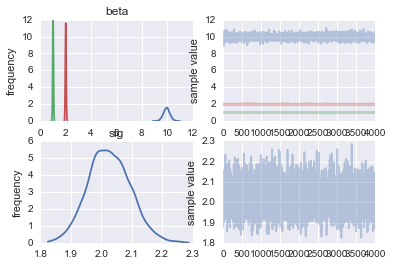

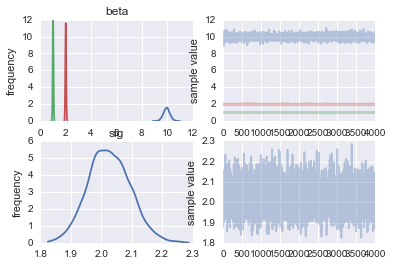

In [49]:
fit.plot()

In [50]:
with open('18_2.pickle', 'wb') as f:
    pickle.dump(sm, f)
    pickle.dump(fit,f)

In [ ]:
with open('18_2.pickle', 'rb') as f: # 読み込む時
    sm = pickle.load(f)
    fit = pickle.load(f)

In [56]:
stanfit_to_dataframe(fit)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta[0],9.950705,0.005552,0.260593,9.443962,9.782230,9.953573,10.115552,10.476434,2203.0,1.001037
beta[1],0.996125,0.000647,0.033177,0.931516,0.974072,0.996159,1.018838,1.061134,2632.0,1.001470
beta[2],1.995000,0.000680,0.034408,1.927427,1.971513,1.995102,2.018114,2.063010,2563.0,0.999755
sig,2.026138,0.001268,0.069310,1.894899,1.978213,2.023927,2.072360,2.166341,2987.0,1.000031
lp__,-481.121900,0.035069,1.405399,-484.766002,-481.783746,-480.798544,-480.101960,-479.406261,1606.0,0.999935


In [60]:
data = fit.extract()

In [84]:
data.keys()

odict_keys(['beta', 'sig', 'lp__'])

In [86]:
data['beta'].shape

(4000, 3)

In [97]:
np.mean(data['beta'][:,2])

1.9949998276929968

In [116]:
fitdata = pd.DataFrame({'beta0' : data['beta'][:,0] , 'beta1' : data['beta'][:,1] , 'beta2' : data['beta'][:,2] , 'sigma' :data['sig']})

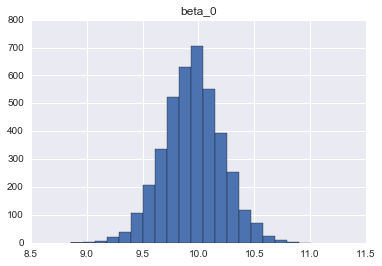

In [129]:
plt.hist(fitdata['beta0'],bins=20)
plt.title('beta_0');

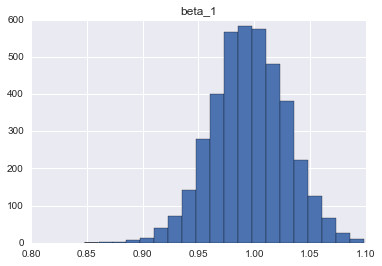

In [132]:
plt.hist(fitdata['beta1'],bins=20)
plt.title('beta_1');

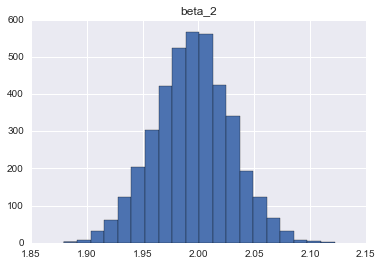

In [131]:
plt.hist(fitdata['beta2'],bins=20)
plt.title('beta_2');

## (B)1予測変数

In [134]:
Mydata.head(2)

,x1,x2,y
0,6.248172,6.413018,27.728072
1,0.547031,6.056001,22.440026


In [136]:
standata.keys()

dict_keys(['N', 'M', 'X', 'Y'])

In [139]:
X = np.concatenate([np.ones(N),Mydata['x1']]).reshape(2,N)
X = X.T

In [141]:
standata = {'N':N, 'M':2, 'X':X, 'Y':Mydata['y']}

In [142]:
fit_b = sm.sampling(standata)

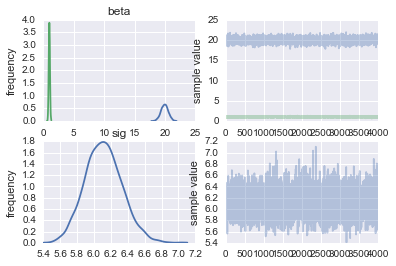

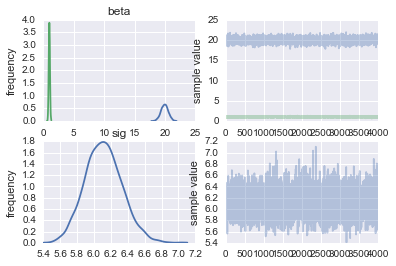

In [143]:
fit_b.plot()

In [144]:
stanfit_to_dataframe(fit_b)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta[0],19.947439,0.014831,0.599157,18.748332,19.541609,19.953767,20.348359,21.120773,1632.0,1.001340
beta[1],1.009096,0.002600,0.101095,0.813180,0.940862,1.009681,1.078059,1.203118,1512.0,1.001405
sig,6.114118,0.004303,0.218752,5.709558,5.961903,6.108372,6.254944,6.568900,2584.0,1.000802
lp__,-923.625425,0.032148,1.182516,-926.641265,-924.175810,-923.336313,-922.753280,-922.259261,1353.0,1.000708


In [145]:
with open('18_2_b.pickle', 'wb') as f:
    pickle.dump(fit_b,f)

In [146]:
data_b = fit_b.extract()

In [147]:
data_b

OrderedDict([('beta', array([[ 20.3400961 ,   1.00361156],
                     [ 20.71071409,   0.85965329],
                     [ 19.82197042,   1.05869444],
                     ..., 
                     [ 20.09424074,   0.95016077],
                     [ 19.91387529,   0.98429777],
                     [ 21.03643074,   0.84059339]])),
             ('sig',
              array([ 6.05103907,  6.00380006,  6.18298508, ...,  6.59848366,
                      6.2212216 ,  5.79980692])),
             ('lp__',
              array([-922.9050766 , -923.36088835, -922.43029504, ..., -924.81048105,
                     -922.48055828, -924.99610559]))])

In [148]:
fitdata_b = pd.DataFrame({'beta0' : data_b['beta'][:,0] , 'beta1' : data_b['beta'][:,1] , 'sigma' :data['sig']})

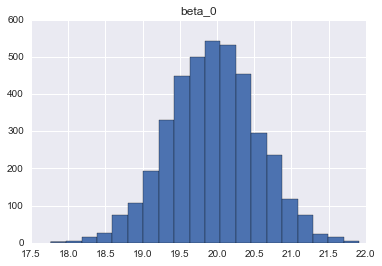

In [150]:
plt.hist(fitdata_b['beta0'],bins=20)
plt.title('beta_0');

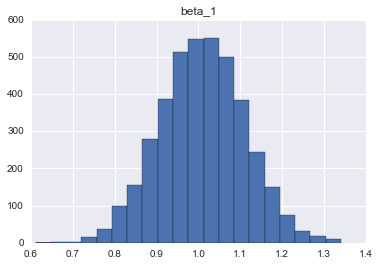

In [151]:
plt.hist(fitdata_b['beta1'],bins=20)
plt.title('beta_1');

## (C)データの101行目から150目

In [172]:
Mydata.iloc[100:150,]

,x1,x2,y
100,6.437847,8.914670,34.921785
101,0.931271,6.355154,24.551838
102,0.780555,4.954432,22.297365
103,6.996715,9.439274,35.300622
104,8.554148,0.195151,18.008446
105,5.288584,1.961516,18.444299
106,1.033909,0.511602,15.273377
107,0.868890,7.490675,24.043826
108,4.019603,0.446168,14.721405
109,4.637931,3.928920,22.327247


In [173]:
from mpl_toolkits.mplot3d import Axes3D

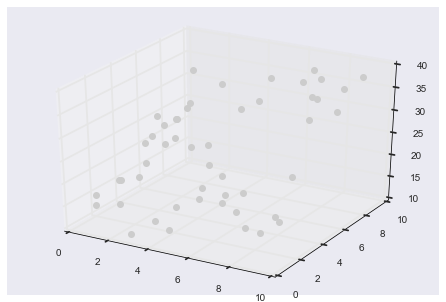

In [184]:
fig = plt.figure()
ax = Axes3D(fig)
#ax.plot([1,2],[1,2],[1,2],"o")
ax.plot(np.array(Mydata.iloc[100:150,]['x1']),np.array(Mydata.iloc[100:150,]['x2']), np.array(Mydata.iloc[100:150,]['y']), "o", color="#cccccc")

# エクササイズ18.3

# エクササイズ18.4